In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from model import HawkesTransformer
from train import train, run_epoch
from dataset_wrapper import LobDataset

In [4]:
TRAIN_MODEL = True
GLOBAL_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
GLOBAL_SEED = 42

In [5]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Dec 12 18:39:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
data = np.load('/content/drive/MyDrive/LOB datasets/dataset_filtered_ETH.npy')
data.shape

(527, 3000, 3)

In [7]:
train_size, val_size = 395, 66

train_data, val_data, test_data = data[:train_size], data[train_size:train_size + val_size], data[train_size + val_size:]
print("Train size:", train_data.shape)
print("Val size:", val_data.shape)
print("Test size:", test_data.shape)

Train size: (395, 3000, 3)
Val size: (66, 3000, 3)
Test size: (66, 3000, 3)


In [8]:
train_dset = LobDataset(train_data, slice_inputs=False)
val_dset = LobDataset(val_data, slice_inputs=False)
test_dset = LobDataset(test_data, slice_inputs=False)

train_loader = utils_data.DataLoader(train_dset, batch_size=5, shuffle=True)
val_loader = utils_data.DataLoader(val_dset, batch_size=5, shuffle=False)
test_loader = utils_data.DataLoader(test_dset, batch_size=5, shuffle=False)

In [9]:
model = HawkesTransformer(2, GLOBAL_DEVICE, 512, 4, 1024, 4, 0.1, 'relu').to(GLOBAL_DEVICE)

if TRAIN_MODEL:
    optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, threshold=0.001, patience=5, verbose=True)
    n_epochs  = 50

    train_history, val_history = train(model, n_epochs, optimizer, train_loader, val_loader, scheduler, GLOBAL_DEVICE, verbose=True, freq=1,\
                                       early_stopping=True, patience=10)
else:
    model.load_state_dict(torch.load('model_weights.pth'))

[ Epoch 1 ]
(Training)     log-likelihood: -4.126281160996835, RMSE: 17.552611585737534, CE: 0.6950866343963283, accuracy: 0.5508823616310922
(Validation)   log-likelihood: -3.787676846590909, RMSE: 14.410123001890824, CE: 0.6835600905300978, accuracy: 0.5696747400648701
Time elapsed: 40.36 s
[ Epoch 2 ]
(Training)     log-likelihood: -3.881345955300633, RMSE: 15.637750375713091, CE: 0.6841461031578037, accuracy: 0.5719780011058538
(Validation)   log-likelihood: -3.806044645675505, RMSE: 14.241907765385427, CE: 0.6837386649400811, accuracy: 0.5696545313084159
Time elapsed: 80.76 s
[ Epoch 3 ]
(Training)     log-likelihood: -3.8782832212552742, RMSE: 15.417802430314564, CE: 0.6840928887226649, accuracy: 0.5729884645092668
(Validation)   log-likelihood: -3.785026002209596, RMSE: 14.254066044363404, CE: 0.6835653918750221, accuracy: 0.5696545313084159
Time elapsed: 121.19 s
[ Epoch 4 ]
(Training)     log-likelihood: -3.87592611089135, RMSE: 15.353016164635953, CE: 0.6835964028489454, accu

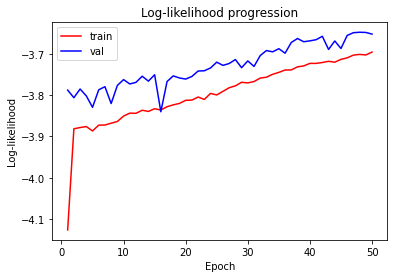

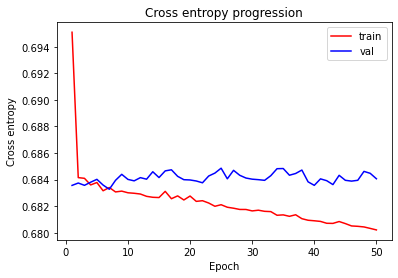

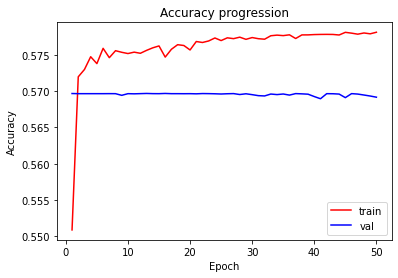

In [10]:
# If model was trained, output plots

if TRAIN_MODEL:
    epochs = list(range(1, n_epochs + 1))

    plt.plot(epochs, train_history['log-likelihood'], c='r', label='train')
    plt.plot(epochs, val_history['log-likelihood'], c='b', label='val')
    plt.title("Log-likelihood progression")
    plt.xlabel("Epoch")
    plt.ylabel("Log-likelihood")
    plt.legend()
    plt.show()

    plt.plot(epochs, train_history['cross entropy'], c='r', label='train')
    plt.plot(epochs, val_history['cross entropy'], c='b', label='val')
    plt.title("Cross entropy progression")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy")
    plt.legend()
    plt.show()

    plt.plot(epochs, train_history['accuracy'], c='r', label='train')
    plt.plot(epochs, val_history['accuracy'], c='b', label='val')
    plt.title("Accuracy progression")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [11]:
model.eval()
test_ll, test_mse, test_ce, test_accuracy = run_epoch(model, test_loader, GLOBAL_DEVICE)

In [12]:
print("Test Log-Likelihood:", test_ll)
print("Test RMSE:", np.sqrt(test_mse))
print("Test CrossEntropy:", test_ce)
print("Test accuracy:", test_accuracy)

Test Log-Likelihood: -3.939160974984217
Test RMSE: 15.495815937487857
Test CrossEntropy: 0.6834320836487005
Test accuracy: 0.5699930279790233
